# PDB files

Here I will show how to parse PDB and PDBx/mmCIF files to obtain some structural data, and possibly to visualise the 3D conformation. We will use [Biopython](https://biopython.org/), which is a fairly comprehensive Python library to handle many use cases. Before starting, don't forget to install it:

```
pip install biopython
```

Focussing on structural data, Biopython can parse most of the standard file formats (PDB, PDBx/mmCIF, and more). We start by adding some magic to remove annoying warnings (don't do this while you are coding: some warnings are useful!)

In [1]:
import warnings
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

import matplotlib.pyplot as plt
import numpy as np

Then we parse two files containing the `1a3n` structure. Note that you should download these files and put them in the current working folder beforehand: [1a3n.pdb](https://files.rcsb.org/download/1A3N.pdb) and [1a3n.cif](https://files.rcsb.org/download/1A3N.cif).

In [2]:
from Bio.PDB.PDBParser import PDBParser

pdb_parser = PDBParser(PERMISSIVE=1)
pdb_structure = pdb_parser.get_structure("1a3n", "1a3n.pdb")

from Bio.PDB.MMCIFParser import MMCIFParser

cif_parser = MMCIFParser()
cif_structure = cif_parser.get_structure("1a3n", "1a3n.cif")

The only difference between the two structures is the file they have been read from, so in the following we will be using only one of them.

Here I refer to [Biopython's documentation](https://biopython.org/wiki/The_Biopython_Structural_Bioinformatics_FAQ). The Structure object follows the so-called **SMCRA** (Structure/Model/Chain/Residue/Atom) architecture:

* A structure consists of models
* A model consists of chains
* A chain consists of residues
* A residue consists of atoms

The hierarchy can be traversed quite naturally:

In [4]:
i = 0
for model in cif_structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                if i < 10: # print the first ten to avoid flooding the output
                    print(atom)
                i += 1

<Atom N>
<Atom CA>
<Atom C>
<Atom O>
<Atom CB>
<Atom CG1>
<Atom CG2>
<Atom N>
<Atom CA>
<Atom C>


List of entities can also be obtained directly, and there exist some auxiliary functions that make life easier:

In [5]:
# Iterate over all residues
Ca_centre_of_mass = np.zeros(3)
for i, residue in enumerate(cif_structure.get_residues()):
    if i < 10:
        print(residue, residue.get_parent())

# Iterate over all atoms
for i, atom in enumerate(cif_structure.get_atoms()):
    if i < 10:
        print(atom)

<Residue VAL het=  resseq=1 icode= > <Chain id=A>
<Residue LEU het=  resseq=2 icode= > <Chain id=A>
<Residue SER het=  resseq=3 icode= > <Chain id=A>
<Residue PRO het=  resseq=4 icode= > <Chain id=A>
<Residue ALA het=  resseq=5 icode= > <Chain id=A>
<Residue ASP het=  resseq=6 icode= > <Chain id=A>
<Residue LYS het=  resseq=7 icode= > <Chain id=A>
<Residue THR het=  resseq=8 icode= > <Chain id=A>
<Residue ASN het=  resseq=9 icode= > <Chain id=A>
<Residue VAL het=  resseq=10 icode= > <Chain id=A>
<Atom N>
<Atom CA>
<Atom C>
<Atom O>
<Atom CB>
<Atom CG1>
<Atom CG2>
<Atom N>
<Atom CA>
<Atom C>


How do we extract the sequence of the chains composing the structure (or model, more correctly)? We have to first convert the structure to a list of peptides, and then we can use the `get_sequence` method:

In [6]:
from Bio.PDB.Polypeptide import PPBuilder

builder = PPBuilder()
peptides = builder.build_peptides(cif_structure[0])
for i, peptide in enumerate(peptides):
    print("Chain n.", i)
    print(peptide.get_sequence())

Chain n. 0
VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
Chain n. 1
HLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH
Chain n. 2
VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
Chain n. 3
HLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH


Note that we can also directly extract some interesting information. We can write a function that computes the gyration radius of the $C^\alpha$ atoms:

In [49]:
def gyration_radius(peptide):
    com = np.zeros(3, dtype="float")
    N_residues = 0
    for residue in peptide:
        if "CA" in residue:
            com += residue["CA"].get_coord()
            N_residues += 1
    com /= N_residues

    Rg2 = 0
    for residue in peptide:
        if "CA" in residue:
            diff = com - residue["CA"].get_coord()
            Rg2 += np.dot(diff, diff)
    Rg2 /= N_residues

    return np.sqrt(Rg2)

for i, peptide in enumerate(peptides):
    print("Chain", i, "- Radius of gyration:", gyration_radius(peptide))

Chain 0 - Radius of gyration: 10.362613301558348
Chain 1 - Radius of gyration: 9.878333084808107
Chain 2 - Radius of gyration: 4.667428443875794
Chain 3 - Radius of gyration: 4.8520647742941065
Chain 4 - Radius of gyration: 2.858095120472412
Chain 5 - Radius of gyration: 12.778369940115873
Chain 6 - Radius of gyration: 8.316140190690957
Chain 7 - Radius of gyration: 8.525369586663237
Chain 8 - Radius of gyration: 18.99122127409389
Chain 9 - Radius of gyration: 11.863498691490266
Chain 10 - Radius of gyration: 10.245707294421123
Chain 11 - Radius of gyration: 9.531071814886266
Chain 12 - Radius of gyration: 11.789954906791744
Chain 13 - Radius of gyration: 14.666086787126032
Chain 14 - Radius of gyration: 13.467170048038037
Chain 15 - Radius of gyration: 7.739828087258082
Chain 16 - Radius of gyration: 4.345251032439649
Chain 17 - Radius of gyration: 7.87172938457329
Chain 18 - Radius of gyration: 3.4885173799185925
Chain 19 - Radius of gyration: 1.902993605861067


 We can also compute the dihedral angles of the chain backbones:

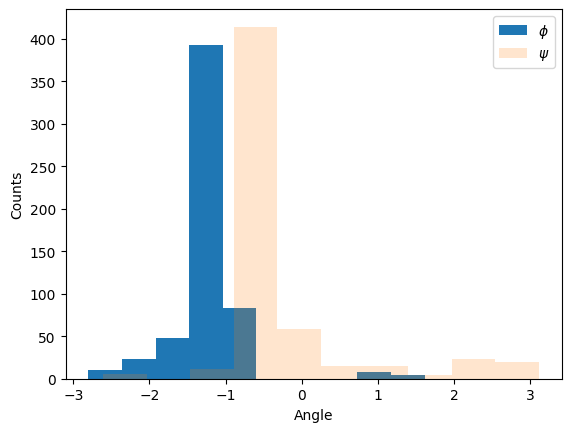

In [16]:
phis = []
psis = []
for peptide in peptides:
    angles = peptide.get_phi_psi_list()
    phis += [angle[0] for angle in angles if angle[0] is not None]
    psis += [angle[1] for angle in angles if angle[1] is not None]

plt.hist(phis, label="$\phi$", alpha=1)
plt.hist(psis, label="$\psi$", alpha=0.2)
plt.xlabel("Angle")
plt.ylabel("Counts")
plt.legend()

If we want to compute something a bit less standard (like the $\omega$ dihedral, which is the rotation around the peptide bond), we have to write the logic ourselves: here we pass the positions of the $C_\alpha$ and $C$ atoms of residue $i$ and of the $N$ and $C_\alpha$ atoms of residue $(i + 1)$ to the Biopython's `calc_dihedral` function, which computes and returns the associated dihedral, which in this case is $\omega$.

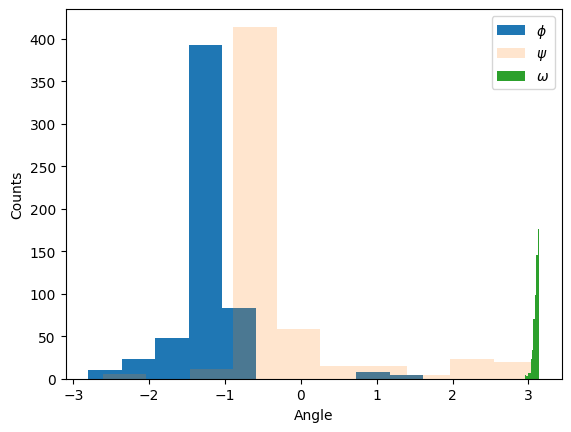

In [17]:
from Bio.PDB.vectors import calc_dihedral

omegas = []
for peptide in peptides:
    for res in range(0, len(peptide) - 1):
        # get vectors for this peptide and the N from the subsequent peptide
        CA = peptide[res]['CA'].get_vector()
        C = peptide[res]['C'].get_vector()
        N_next = peptide[res + 1]['N'].get_vector()
        C_next = peptide[res + 1]['CA'].get_vector()
        omega = calc_dihedral(CA, C, N_next, C_next)
        omegas.append(abs(omega))

plt.hist(phis, label="$\phi$", alpha=1)
plt.hist(psis, label="$\psi$", alpha=0.2)
plt.hist(omegas, label="$\omega$", alpha=1)
plt.xlabel("Angle")
plt.ylabel("Counts")
plt.legend()

# Visualisation

In addition to the tools discussed during the lecture, it is also possible to visualise a PDB file directly in a Jupyter notebook with [nglview](), which can be installed on `conda` with:

```
$ conda install nglview -c conda-forge
```

or through `pip`:

```
$ pip install nglview
```

**Nota Bene:** in some cases you also have to manually install `jupyterlab`, and often the visualisation will not work regardless. Using a different browser can help

In [15]:
import nglview
print(nglview.__version__)

3.1.2


In [16]:
view = nglview.show_file("../files/1ecl.pdb")
view

NGLWidget()

In [17]:
view = nglview.show_biopython(pdb_structure)
view

NGLWidget()

# The gyration radius as a function of protein size

We can compute the gyration radius of many proteins to see how $R_g$ depends on the number of residues $N$. Note that to run the next cell you will have to download a file containing a curated list of PDB files from [here](https://zenodo.org/records/5777651). Be careful, the smallest file (`https://zenodo.org/records/5777651/files/top2018_pdbs_mc_filtered_hom30.tar.gz?download=1`) is almost 1 GB in size! You will then have to unpack the archive file and update the path in the snippet below.
Note that the analysis should take at several minutes, depending on your computer.

In [73]:
from glob import glob

sizes = []
radii = []
for i, pdb in enumerate(glob("/home/lorenzo/Downloads/top2018_pdbs_mc_filtered_hom30/*/*/*pdb")):
    structure = pdb_parser.get_structure(pdb[:-4], pdb)
    peptides = builder.build_peptides(structure[0])
    for peptide in peptides:
        if len(peptide) > 10:
            sizes.append(len(peptide))
            radii.append(gyration_radius(peptide))

If we plot the results, we can see that small proteins behave more or less like self-avoiding walks, while larges one appear more compact, as their gyration radius seems to scale with an exponent that is closer to $1/3$ rather than $0.588$.

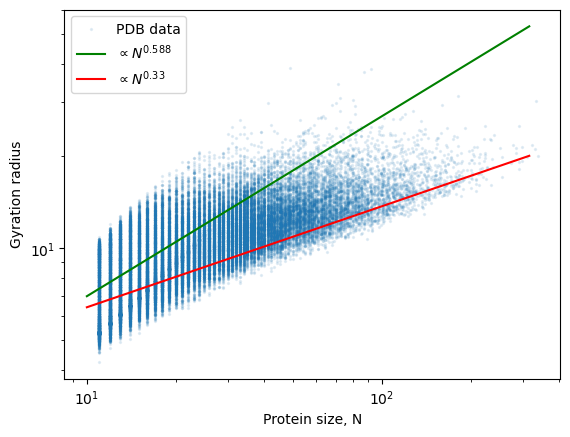

In [80]:
plt.scatter(sizes, radii, s=2, alpha=0.1, label="PDB data")

x = np.logspace(1, 2.5)
y = 1.8 * x**0.588
plt.plot(x, y, 'g', label="$\propto N^{0.588}$")
y = 3 * x**0.33
plt.plot(x, y, 'r', label="$\propto N^{0.33}$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Protein size, N")
plt.ylabel("Gyration radius")
plt.legend()